In [1]:
from rtlobs import collect as col
from rtlobs import post_process as pp

In [2]:
p_tot = col.run_total_power_int( 1024, 49.6, 2.048e6, 91.3e6, 5)
print('Uncalibrated total power measurement: {}'.format(p_tot))

Initializing rtl-sdr with pyrtlsdr:
  sample rate: 2.048 MHz
  center frequency 91.3 MHz
  gain: 49.6 dB
  num samples per call: 1024
  requested integration time: 5s
  => num samples to collect: 10240000
  => est. num of calls: 10000
Integration began at Sun, 12 Jan 2020 11:54:27
Integration ended at Sun, 12 Jan 2020 11:54:33 after 6.013633966445923 seconds.
10000 calls were made to SDR.
10240000 samples were measured at 91.3 MHz
for an effective integration time of 5.00s
Uncalibrated total power measurement: 3.5038605344098193e-06


Initializing rtl-sdr with pyrtlsdr:
  sample rate: 2.048000 MHz
  center frequency 91.300000 MHz
  gain: 49 dB
  num samples per call: 1024
  requested integration time: 5s
  => num samples to collect: 10240000
  => est. num of calls: 10000
Integration began at Sun, 12 Jan 2020 11:54:33
Integration ended at Sun, 12 Jan 2020 11:54:45 after 11.643928527832031 seconds.
10000 spectra were measured at 91300000.0.
for an effective integration time of 5.00s


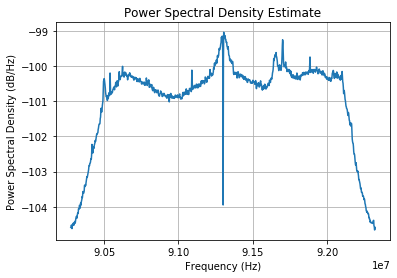

In [3]:
f, p = col.run_spectrum_int(1024, 49.6, 2.048e6, 91.3e6, 5)
fig = pp.plot_spectrum(f, p)

Initializing rtl-sdr with pyrtlsdr:
  sample rate: 2.048000 MHz
  center frequency 89.090000 MHz
  gain: 49 dB
  num samples per call: 2048
  requested integration time: 2.0s
  => num samples to collect: 4096000
  => est. num of calls: 2000
  => num samples on each dwell: 409600
  => est. num of calls on each dwell: 200
  => num dwells total: 10
Integration began at Sun, 12 Jan 2020 11:54:46
Integration ended at Sun, 12 Jan 2020 11:54:49 after 3.4460949897766113 seconds.
2000 spectra were measured, split between 89090000.0 and 89110000.0.
for an effective integration time of 2.00s


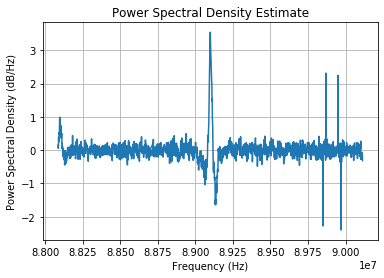

In [4]:
f, p = col.run_fswitch_int(2048, 49.6, 2.048e6, 89.09e6, 89.11e6, 2.0, fswitch=5)
fig = pp.plot_spectrum(f, p)